# Oil prediction analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xgboost as xgb
# pip install xgboost
import seaborn as sns
import operator as op
import typing as t
import math
import statistics
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn import decomposition
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.datasets import make_classification

from sklearn.neural_network import MLPRegressor

from sklearn.svm import SVR

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from __future__ import annotations

from collections import abc

from functools import partial

from tqdm.auto import trange
from tqdm import trange

from xgboost import XGBClassifier
from xgboost import XGBRegressor

from eBoruta import eBoruta, TrialData, Features, Dataset, setup_logger  
# pip install git+https://github.com/edikedik/eBoruta.git

2023-05-30 19:19:42.893028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load and analysis of the data

We selected some parameters that could influence the price of oil such as:  
'Year', 'Price Cononut oil', 'Price Sugar', 'Us crude oil reserves', 'Quantity oil embarked', 'Quantity goods embarked', 'Pandemic (covid)', 'War','Electric car registrations', 'World imports', 'World exports', 'Value of Solar Consumption', 'Inflation', 'Value of Wind Consumption', 'Value of Nuclear Consumption', 'Value of Natural Gas Consumption', 'Population', 'OPEC cuts on production', 'Price gold', 'GDP Growth','Crude oil and NGL production', 'World-oil demand', 'Value of Freight Transport'.

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


,Year,Oil brent price ($/bbl),Cononut oil ($/mt),Sugar ($/kg),Us crude oil reserves,Quantity oil embarked (million of tons),Quantity goods embarked (million of tons),Pandemic (covid),War,Electric car registrations,...,Value of Wind Consumption (EJ),Value of Nuclear Consumption (EJ),Value of Natural Gas Consumption (BcF),Population,OPEC cuts on production,Price gold,GDP Growth,Crude oil and NGL production,World-oil demand,Value of Freight Transport
count,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,6.240000e+02,...,624.000000,624.000000,624.000000,6.240000e+02,624.000000,624.000000,624.000000,624.000000,624.000000,6.240000e+02
mean,1995.958333,37.451538,743.386122,0.269103,28183.788462,1539.002240,5854.919505,0.038462,0.057692,8.424563e+05,...,2.414431,18.362341,220.820166,5.774825e+06,0.024038,599.331763,3.152875,3516.240577,3436.283654,1.337433e+08
std,15.023130,30.523005,383.579919,0.144167,5836.814615,244.727308,2715.516484,0.192462,0.233348,2.685918e+06,...,4.370277,9.076341,85.328111,1.260299e+06,0.153291,491.963383,1.631201,615.261810,583.575264,1.109539e+08
min,1970.000000,1.210000,200.000000,0.060000,19121.000000,1049.000000,2605.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.727978,93.025514,3.695380e+06,0.000000,34.990000,-3.115404,2490.520000,2379.400000,1.017289e+07
25%,1982.979167,16.052500,456.750000,0.170000,22454.250000,1356.250000,3495.750000,0.000000,0.000000,0.000000e+00,...,0.000311,9.042216,141.697022,4.670898e+06,0.000000,293.637500,2.519675,2966.917500,2959.425000,4.127752e+07
50%,1995.958333,27.510000,643.000000,0.240000,27495.500000,1594.500000,4704.500000,0.000000,0.000000,0.000000e+00,...,0.092967,23.426071,208.670411,5.784171e+06,0.000000,387.250000,3.307856,3385.230000,3314.160000,8.353648e+07
75%,2008.937500,54.635000,916.282500,0.320000,32854.250000,1741.000747,8084.055192,0.000000,0.000000,3.475000e+03,...,2.375486,25.325763,285.765447,6.833263e+06,0.000000,920.437500,4.146743,4061.740000,3991.250000,2.438308e+08
max,2021.916667,133.870000,2256.000000,1.240000,39001.000000,1881.049999,11070.533090,1.000000,1.000000,1.540493e+07,...,17.503339,27.470872,390.634419,7.909283e+06,1.000000,1964.900000,6.407434,4619.320000,4455.850000,3.381681e+08


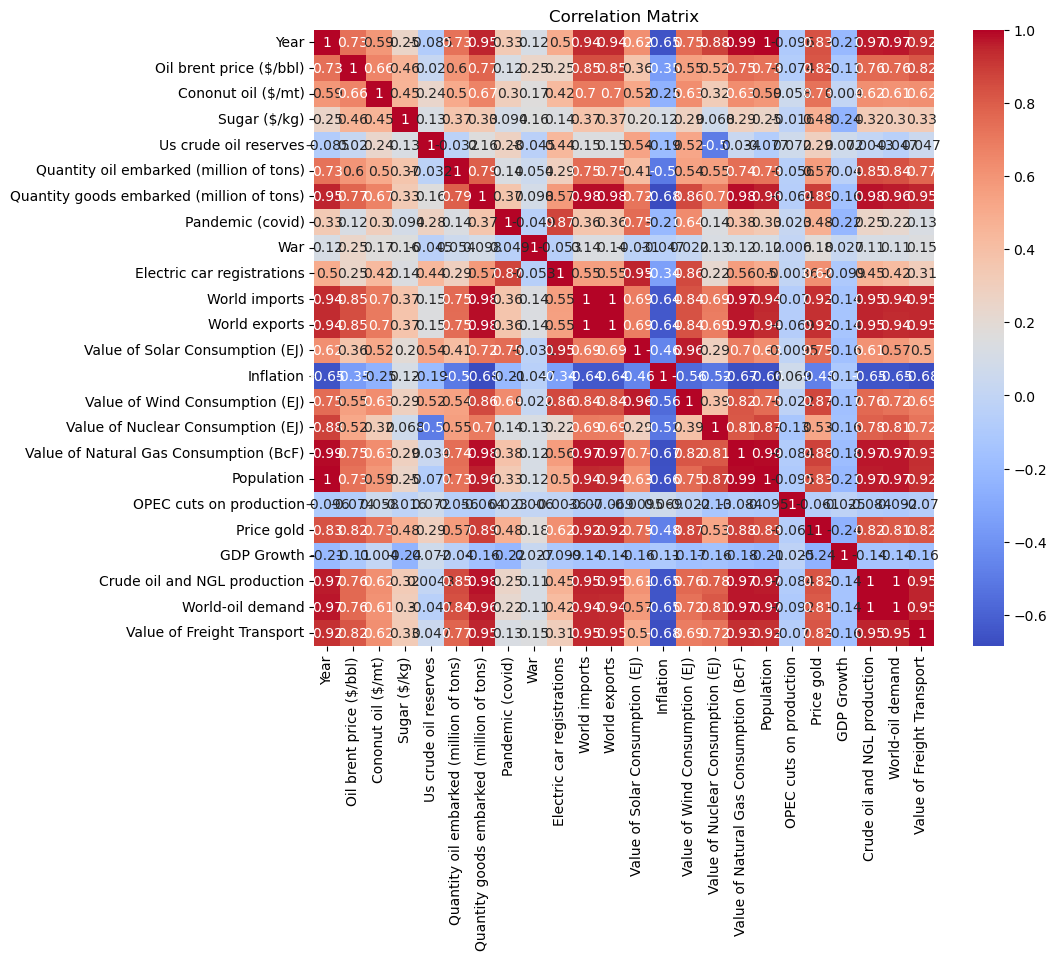

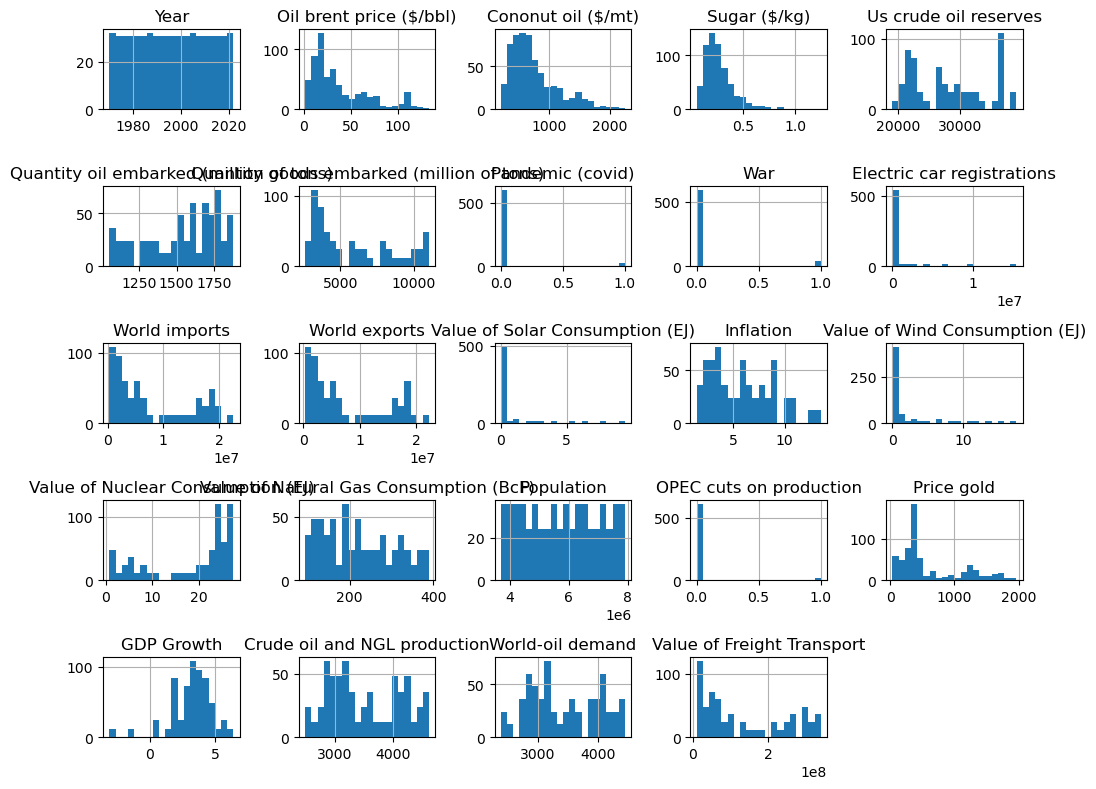

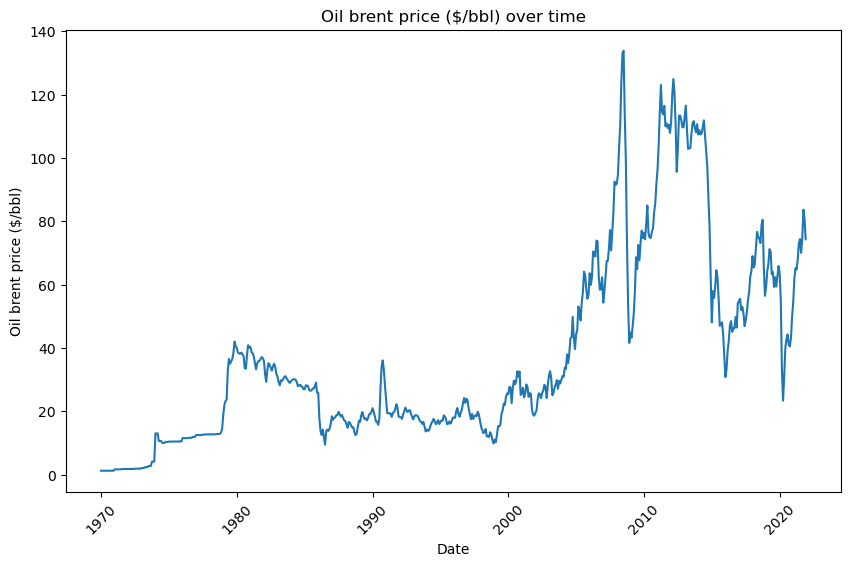

In [2]:
# Load the csv
df = pd.read_csv('data_final1.csv')

x = df.drop(['Oil brent price ($/bbl)'], 1)
y = df['Oil brent price ($/bbl)']

# Normalize x
min_vals = x.min()
max_vals = x.max()
x = (x - min_vals) / (max_vals - min_vals)

display(df.describe())

corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

df.hist(figsize=(10, 8), bins=20)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Oil brent price ($/bbl)'])
plt.xlabel('Date')
plt.ylabel('Oil brent price ($/bbl)')
plt.title('Oil brent price ($/bbl) over time')
plt.xticks(rotation=45)
plt.show()


# Explore different models 

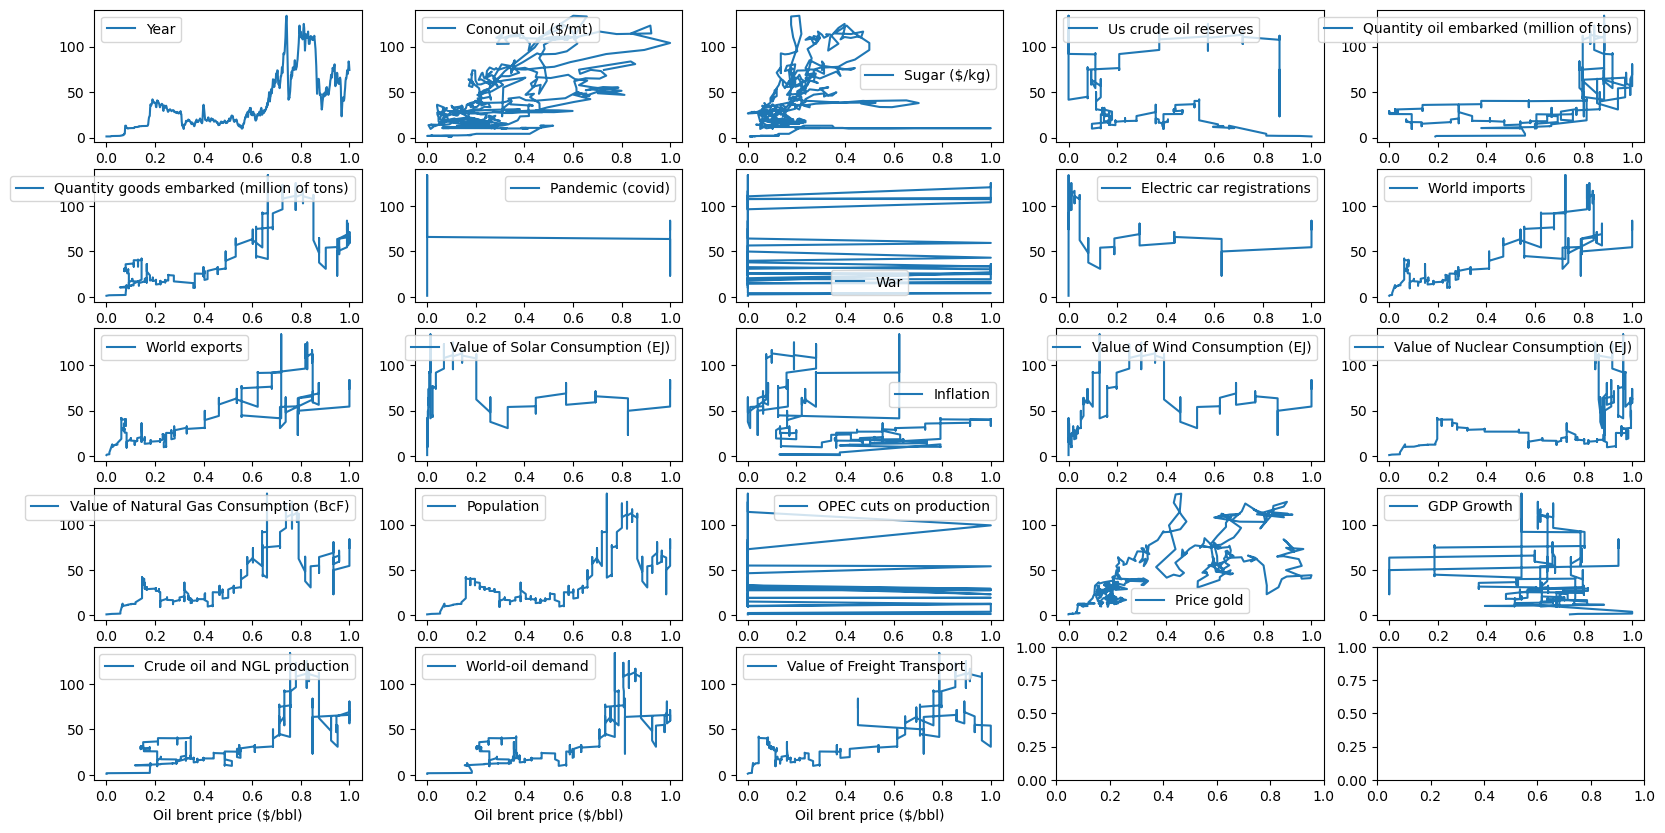

In [3]:
features = ['Year', 'Cononut oil ($/mt)', 'Sugar ($/kg)', 'Us crude oil reserves', 
            'Quantity oil embarked (million of tons)', 'Quantity goods embarked (million of tons)', 'Pandemic (covid)', 'War', 
            'Electric car registrations', 'World imports', 'World exports', 'Value of Solar Consumption (EJ)', 'Inflation',
            'Value of Wind Consumption (EJ)', 'Value of Nuclear Consumption (EJ)', 'Value of Natural Gas Consumption (BcF)',
            'Population', 'OPEC cuts on production', 'Price gold', 'GDP Growth', 'Crude oil and NGL production', 
            'World-oil demand', 'Value of Freight Transport']

fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (20, 10))
for i, feature in enumerate(features):
    axes[int(i/5)][i%5].plot(x.loc[:, feature], y, label = feature)
    axes[int(i/5)][i%5].set_xlabel("Oil brent price ($/bbl)")
    axes[int(i/5)][i%5].legend()
plt.show()

# MODEL TRAINING

## Data preprocessing

In [4]:
data= pd.read_csv("data_final1.csv") #loading
data

,Year,Oil brent price ($/bbl),Cononut oil ($/mt),Sugar ($/kg),Us crude oil reserves,Quantity oil embarked (million of tons),Quantity goods embarked (million of tons),Pandemic (covid),War,Electric car registrations,...,Value of Wind Consumption (EJ),Value of Nuclear Consumption (EJ),Value of Natural Gas Consumption (BcF),Population,OPEC cuts on production,Price gold,GDP Growth,Crude oil and NGL production,World-oil demand,Value of Freight Transport
0,1970.000000,1.21,405.80,0.08,39001,1207.000000,2605.00000,0,0,0,...,0.000000,0.727978,93.025514,3695380,0,34.99,3.968558,2490.52,2379.40,10172892.0
1,1970.083333,1.21,406.28,0.07,39001,1207.000000,2605.00000,0,0,0,...,0.000000,0.727978,93.025514,3695380,0,34.99,3.968558,2490.52,2379.40,10172892.0
2,1970.166667,1.21,406.28,0.07,39001,1207.000000,2605.00000,0,0,0,...,0.000000,0.727978,93.025514,3695380,0,35.20,3.968558,2490.52,2379.40,10172892.0
3,1970.250000,1.21,406.28,0.08,39001,1207.000000,2605.00000,0,0,0,...,0.000000,0.727978,93.025514,3695380,0,35.30,3.968558,2490.52,2379.40,10172892.0
4,1970.333333,1.21,399.19,0.08,39001,1207.000000,2605.00000,0,0,0,...,0.000000,0.727978,93.025514,3695380,0,35.85,3.968558,2490.52,2379.40,10172892.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,2021.583333,70.02,1493.64,0.43,36385,1700.358001,10985.36591,1,0,15404930,...,17.503339,25.165261,390.634419,7909283,0,1825.75,5.869779,4296.19,4069.98,158796478.5
620,2021.666667,74.60,1485.00,0.43,36385,1700.358001,10985.36591,1,0,15404930,...,17.503339,25.165261,390.634419,7909283,0,1814.85,5.869779,4296.19,4069.98,158796478.5
621,2021.750000,83.65,1922.86,0.42,36385,1700.358001,10985.36591,1,0,15404930,...,17.503339,25.165261,390.634419,7909283,0,1742.80,5.869779,4296.19,4069.98,158796478.5
622,2021.833333,80.77,1960.68,0.43,36385,1700.358001,10985.36591,1,0,15404930,...,17.503339,25.165261,390.634419,7909283,0,1769.15,5.869779,4296.19,4069.98,158796478.5


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 24 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Year                                       624 non-null    float64
 1   Oil brent price ($/bbl)                    624 non-null    float64
 2   Cononut oil ($/mt)                         624 non-null    float64
 3   Sugar ($/kg)                               624 non-null    float64
 4   Us crude oil reserves                      624 non-null    int64  
 5   Quantity oil embarked (million of tons)    624 non-null    float64
 6   Quantity goods embarked (million of tons)  624 non-null    float64
 7   Pandemic (covid)                           624 non-null    int64  
 8   War                                        624 non-null    int64  
 9   Electric car registrations                 624 non-null    int64  
 10  World imports             

In [6]:
data.describe()

,Year,Oil brent price ($/bbl),Cononut oil ($/mt),Sugar ($/kg),Us crude oil reserves,Quantity oil embarked (million of tons),Quantity goods embarked (million of tons),Pandemic (covid),War,Electric car registrations,...,Value of Wind Consumption (EJ),Value of Nuclear Consumption (EJ),Value of Natural Gas Consumption (BcF),Population,OPEC cuts on production,Price gold,GDP Growth,Crude oil and NGL production,World-oil demand,Value of Freight Transport
count,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,6.240000e+02,...,624.000000,624.000000,624.000000,6.240000e+02,624.000000,624.000000,624.000000,624.000000,624.000000,6.240000e+02
mean,1995.958333,37.451538,743.386122,0.269103,28183.788462,1539.002240,5854.919505,0.038462,0.057692,8.424563e+05,...,2.414431,18.362341,220.820166,5.774825e+06,0.024038,599.331763,3.152875,3516.240577,3436.283654,1.337433e+08
std,15.023130,30.523005,383.579919,0.144167,5836.814615,244.727308,2715.516484,0.192462,0.233348,2.685918e+06,...,4.370277,9.076341,85.328111,1.260299e+06,0.153291,491.963383,1.631201,615.261810,583.575264,1.109539e+08
min,1970.000000,1.210000,200.000000,0.060000,19121.000000,1049.000000,2605.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.727978,93.025514,3.695380e+06,0.000000,34.990000,-3.115404,2490.520000,2379.400000,1.017289e+07
25%,1982.979167,16.052500,456.750000,0.170000,22454.250000,1356.250000,3495.750000,0.000000,0.000000,0.000000e+00,...,0.000311,9.042216,141.697022,4.670898e+06,0.000000,293.637500,2.519675,2966.917500,2959.425000,4.127752e+07
50%,1995.958333,27.510000,643.000000,0.240000,27495.500000,1594.500000,4704.500000,0.000000,0.000000,0.000000e+00,...,0.092967,23.426071,208.670411,5.784171e+06,0.000000,387.250000,3.307856,3385.230000,3314.160000,8.353648e+07
75%,2008.937500,54.635000,916.282500,0.320000,32854.250000,1741.000747,8084.055192,0.000000,0.000000,3.475000e+03,...,2.375486,25.325763,285.765447,6.833263e+06,0.000000,920.437500,4.146743,4061.740000,3991.250000,2.438308e+08
max,2021.916667,133.870000,2256.000000,1.240000,39001.000000,1881.049999,11070.533090,1.000000,1.000000,1.540493e+07,...,17.503339,27.470872,390.634419,7.909283e+06,1.000000,1964.900000,6.407434,4619.320000,4455.850000,3.381681e+08


In [7]:
data.dropna(inplace = True) # remove NaN values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 24 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Year                                       624 non-null    float64
 1   Oil brent price ($/bbl)                    624 non-null    float64
 2   Cononut oil ($/mt)                         624 non-null    float64
 3   Sugar ($/kg)                               624 non-null    float64
 4   Us crude oil reserves                      624 non-null    int64  
 5   Quantity oil embarked (million of tons)    624 non-null    float64
 6   Quantity goods embarked (million of tons)  624 non-null    float64
 7   Pandemic (covid)                           624 non-null    int64  
 8   War                                        624 non-null    int64  
 9   Electric car registrations                 624 non-null    int64  
 10  World imports             

### Manual feature selection and averaging

In [8]:
# discovered function rolling() at:
# https://stackoverflow.com/questions/60274621/calculate-average-of-specified-range-of-values-in-pandas-column-and-store-as-ano
# and function shift() at:
# https://stackoverflow.com/questions/10982089/how-to-shift-a-column-in-pandas-dataframe

# features that shouldn't ever be averaged
no_avg_features = ['Year', 'War', 'OPEC cuts on production', 'Pandemic (covid)']
# features we choose to use
features = ['Year', 'Sugar ($/kg)', 'World imports', 'Inflation', 'Price gold' ]

df = data.loc[:, features]

num_months_avg = 1 # over how many months to take average

take_average = 0 # 1 or 0, indicates whether we do the averaging

for feature in features:
    if feature not in no_avg_features:
        df[feature] = df[feature].rolling(num_months_avg).mean() # average
    elif num_months_avg > 1:
        df[feature] = df[feature].shift(-1) # if taking average, adjust the other features for forecasting

df.dropna(inplace=True)
df.describe()

,Year,Sugar ($/kg),World imports,Inflation,Price gold
count,624.000000,624.000000,6.240000e+02,624.000000,624.000000
mean,1995.958333,0.269103,7.764640e+06,5.798241,599.331763
std,15.023130,0.144167,6.880366e+06,3.000890,491.963383
min,1970.000000,0.060000,3.304243e+05,1.434318,34.990000
25%,1982.979167,0.170000,2.026458e+06,3.285943,293.637500
50%,1995.958333,0.240000,5.365939e+06,5.664361,387.250000
75%,2008.937500,0.320000,1.453177e+07,7.814541,920.437500
max,2021.916667,1.240000,2.258662e+07,13.500000,1964.900000


In [9]:
oil_prices = data.loc[data.Year >= 1970 + take_average*num_months_avg/12, 'Oil brent price ($/bbl)'] # labels
oil_prices

0       1.21
1       1.21
2       1.21
3       1.21
4       1.21
       ...  
619    70.02
620    74.60
621    83.65
622    80.77
623    74.31
Name: Oil brent price ($/bbl), Length: 624, dtype: float64

In [10]:
#normalization:

min_vals = df.min()
max_vals = df.max()
df = (df - min_vals) / (max_vals - min_vals)
df.describe()

,Year,Sugar ($/kg),World imports,Inflation,Price gold
count,624.00000,624.000000,624.000000,624.000000,624.000000
mean,0.50000,0.177206,0.334029,0.361681,0.292419
std,0.28937,0.122175,0.309144,0.248713,0.254915
min,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.25000,0.093220,0.076205,0.153462,0.134020
50%,0.50000,0.152542,0.226252,0.350585,0.182527
75%,0.75000,0.220339,0.638085,0.528791,0.458802
max,1.00000,1.000000,1.000000,1.000000,1.000000


In [11]:
# transform the normalized values back into years
def years_transform(y):
    return y * (max_vals['Year'] - min_vals['Year']) + min_vals['Year']

## The training

In [12]:
# split the data into training and testing sets:
x_train, x_test, y_train, y_test = train_test_split(df, oil_prices, test_size=0.3, shuffle=True)
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

436
436
188
188


In [13]:
model_results = dict() # store the results in the form 
                       # <model> : (<r2_score>, <mse>, <mse_cross_validation>)

### Cross-validation function

In [2]:
def cross_validate(model, x, y, n, score_fn, agg_fn, stratified):
    if stratified:
        kf = StratifiedKFold(n_splits=n)
    else:
        kf = KFold(n_splits=n, shuffle=True)

    scores = []
    for train_idx, test_idx in kf.split(x, y):
        X_train, Y_train = x.iloc[train_idx], y.iloc[train_idx]
        X_test, Y_test = x.iloc[test_idx], y.iloc[test_idx]
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        score = score_fn(Y_test, y_pred)
        scores.append(score)
    return agg_fn(scores)

## Linear regression model

In [15]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_predict_linear = linear_model.predict(x_test)
linear_r2_score = r2_score(y_test, y_predict_linear)
linear_mse = mean_squared_error(y_test, y_predict_linear)
linear_cv = cross_validate(linear_model, df, oil_prices, 4, mean_squared_error, np.mean, False)
print("linear regression r2 score: ", linear_r2_score)
print("linear regression mse: ", linear_mse)
print("linear regression cros-validation score: ", linear_cv)
model_results["linear_regression"] = (linear_r2_score, linear_mse, linear_cv)

linear regression r2 score:  0.7641530766131525
linear regression mse:  189.8531474889204
linear regression cros-validation score:  194.39279868363332


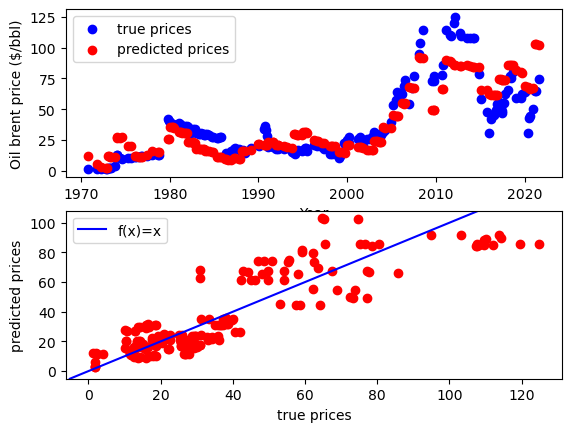

In [16]:
# plot the results of the linear model
years = years_transform(x_test['Year'])
fig, axs = plt.subplots(2)
axs[0].scatter(years, y_test, color = 'blue', label = 'true prices')
axs[0].scatter(years, y_predict_linear, color = 'red', label = 'predicted prices')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Oil brent price ($/bbl)')
axs[0].legend()

axs[1].scatter(y_test, y_predict_linear, color = 'red')
axs[1].axline((0, 0), slope = 1, color = 'blue', label = 'f(x)=x')
axs[1].set_xlabel('true prices')
axs[1].set_ylabel('predicted prices')
axs[1].legend()
plt.show()

## Linear regression with Ridge penalty

In [17]:
alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100, 200] # try all of these values for alpha
alpha_ridge = 1
best_score_ridge = 0

for alpha in alphas:
    #ridge_model = sklearn.linear_model.Ridge(alpha=0.5, normalize = True)
    linear_ridge_model = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=alpha))
    score = cross_validate(linear_ridge_model, x_train, y_train, 10, r2_score, np.mean, False)
    if score > best_score_ridge:
        best_score_ridge = score
        alpha_ridge = alpha

linear_ridge_model = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=alpha_ridge))
linear_ridge_model.fit(x_train, y_train)
y_predict_linear_ridge = linear_ridge_model.predict(x_test)
linear_ridge_r2_score = r2_score(y_test, y_predict_linear_ridge)
linear_ridge_mse = mean_squared_error(y_test, y_predict_linear_ridge)
linear_ridge_cv = cross_validate(linear_ridge_model, df, oil_prices, 4, mean_squared_error, np.mean, False)
print("optimal alpha: ", alpha_ridge)
print("r2 score: ", linear_ridge_r2_score)
print("mse: ", linear_ridge_mse)
print("cross-validation: ", linear_ridge_cv)
model_results["linear_ridge"] = (linear_ridge_r2_score, linear_ridge_mse, linear_ridge_cv)

optimal alpha:  0.05
r2 score:  0.7641758209058976
mse:  189.83483868292421
cross-validation:  194.77221538394076


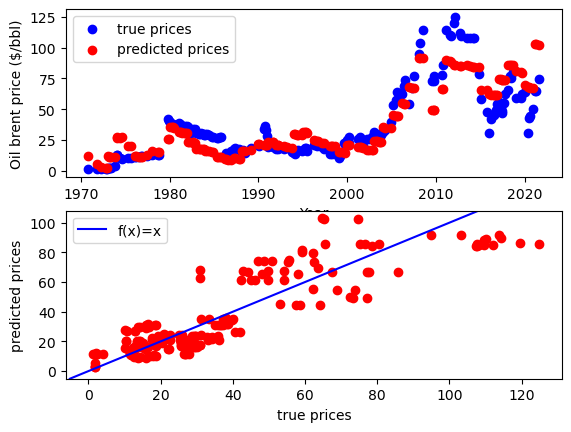

In [18]:
years = years_transform(x_test['Year'])
fig, axs = plt.subplots(2)
axs[0].scatter(years, y_test, color = 'blue', label = 'true prices')
axs[0].scatter(years, y_predict_linear_ridge, color = 'red', label = 'predicted prices')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Oil brent price ($/bbl)')
axs[0].legend()

axs[1].scatter(y_test, y_predict_linear_ridge, color = 'red')
axs[1].axline((0, 0), slope = 1, color = 'blue', label = 'f(x)=x')
axs[1].set_xlabel('true prices')
axs[1].set_ylabel('predicted prices')
axs[1].legend()
plt.show()

## Linear regression with Lasso penalty

In [19]:
alphas = [0.1, 0.5, 1, 5, 10, 20, 50, 100, 200]
alpha_lasso = 1
best_score_lasso = 0

for alpha in alphas:
    linear_lasso_model = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha=alpha))
    score = cross_validate(linear_lasso_model, x_train, y_train, 10, r2_score, np.mean, False)
    if score > best_score_lasso:
        best_score_lasso = score
        alpha_lasso = alpha

linear_lasso_model = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha=alpha_lasso))
linear_lasso_model.fit(x_train, y_train)
y_predict_linear_lasso = linear_lasso_model.predict(x_test)
linear_lasso_r2_score = r2_score(y_test, y_predict_linear_lasso)
linear_lasso_mse = mean_squared_error(y_test, y_predict_linear_lasso)
linear_lasso_cv = cross_validate(linear_lasso_model, df, oil_prices, 4, mean_squared_error, np.mean, False)
print("optimal alpha: ", alpha_lasso)
print("r2 score: ", linear_lasso_r2_score)
print("mse: ", linear_lasso_mse)
print("cv: ", linear_lasso_cv)
model_results["linear_lasso"] = (linear_lasso_r2_score, linear_lasso_mse, linear_lasso_cv)

optimal alpha:  0.1
r2 score:  0.7633612630700941
mse:  190.4905452179864
cv:  193.28070215377556


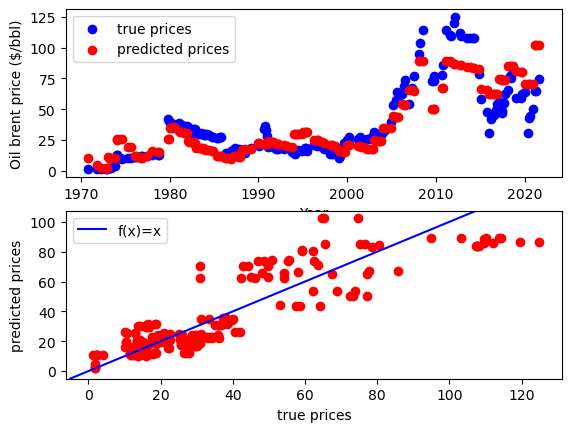

In [20]:
years = years_transform(x_test['Year'])
fig, axs = plt.subplots(2)
axs[0].scatter(years, y_test, color = 'blue', label = 'true prices')
axs[0].scatter(years, y_predict_linear_lasso, color = 'red', label = 'predicted prices')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Oil brent price ($/bbl)')
axs[0].legend()

axs[1].scatter(y_test, y_predict_linear_lasso, color = 'red')
axs[1].axline((0, 0), slope = 1, color = 'blue', label = 'f(x)=x')
axs[1].set_xlabel('true prices')
axs[1].set_ylabel('predicted prices')
axs[1].legend()
plt.show()

## Polynomial regression

In [21]:
polynomial_features = PolynomialFeatures(degree= 2) # results are generally bad, but degree 2 seems to work
linear_regression = LinearRegression(fit_intercept=False)
polynomial_model = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
polynomial_model.fit(x_train, y_train)
y_predict_polynomial = polynomial_model.predict(x_test)
polynomial_r2_score = r2_score(y_test, y_predict_polynomial)
polynomial_mse = mean_squared_error(y_test, y_predict_polynomial)
polynomial_cv = cross_validate(polynomial_model, df, oil_prices, 4, mean_squared_error, np.mean, False)
print("r2 score: ", polynomial_r2_score)
print("mse: ", polynomial_mse)
print("cv: ", polynomial_cv)
model_results["polynomial"] = (polynomial_r2_score, polynomial_mse, polynomial_cv)

r2 score:  0.9310753802454291
mse:  55.48325927669084
cv:  67.31976941384063


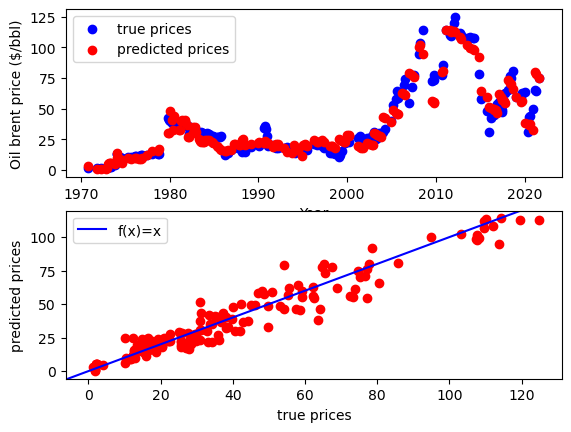

In [22]:
years = years_transform(x_test['Year'])
fig, axs = plt.subplots(2)
axs[0].scatter(years, y_test, color = 'blue', label = 'true prices')
axs[0].scatter(years, y_predict_polynomial, color = 'red', label = 'predicted prices')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Oil brent price ($/bbl)')
axs[0].legend()

axs[1].scatter(y_test, y_predict_polynomial, color = 'red')
axs[1].axline((0, 0), slope = 1, color = 'blue', label = 'f(x)=x')
axs[1].set_xlabel('true prices')
axs[1].set_ylabel('predicted prices')
axs[1].legend()
plt.show()

## Polynomial regression with Ridge penalty

In [23]:
degrees = [2, 3, 4] # try these degrees
alphas = [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 200] # try for these values of alpha
alpha_ridge = 1
degree_ridge = 1
best_score_ridge = 0
for d in degrees:
    for alpha in alphas:
        polynomial_features_ridge = PolynomialFeatures(degree= d)
        linear_regression_ridge = Ridge(alpha = alpha, fit_intercept=False)
        polynomial_model_ridge = Pipeline([("polynomial_features", polynomial_features_ridge), ("linear_regression", linear_regression_ridge)])
        score = cross_validate(polynomial_model_ridge, x_train, y_train, 10, r2_score, np.mean, False)
        if score > best_score_ridge:
            best_score_ridge = score
            alpha_ridge = alpha
            degree_ridge = d
            
polynomial_features_ridge = PolynomialFeatures(degree= degree_ridge)
linear_regression_ridge = Ridge(alpha = alpha_ridge, fit_intercept=False)
polynomial_model_ridge = Pipeline([("polynomial_features", polynomial_features_ridge), ("linear_regression", linear_regression_ridge)])
polynomial_model_ridge.fit(x_train, y_train)
y_predict_polynomial_ridge = polynomial_model_ridge.predict(x_test)
polynomial_ridge_r2_score = r2_score(y_test, y_predict_polynomial_ridge)
polynomial_ridge_mse = mean_squared_error(y_test, y_predict_polynomial_ridge)
polynomial_ridge_cv = cross_validate(polynomial_model_ridge, df, oil_prices, 4, mean_squared_error, np.mean, False)
print("optimal degree: ", degree_ridge)
print("optimal alpha: ", alpha_ridge)
print("r2 score: ", polynomial_ridge_r2_score)
print("mse: ", polynomial_ridge_mse)
print("cv: ", polynomial_ridge_cv)
model_results["polynomial_ridge"] = (polynomial_ridge_r2_score, polynomial_ridge_mse, polynomial_ridge_cv)

optimal degree:  4
optimal alpha:  0.005
r2 score:  0.9439738222549645
mse:  45.10021175566398
cv:  58.406942688419754


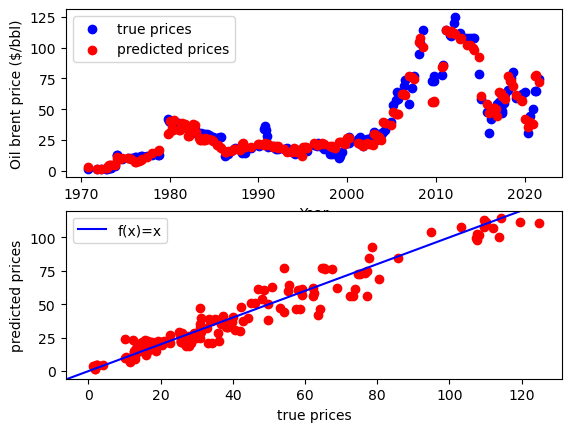

In [24]:
years = years_transform(x_test['Year'])
fig, axs = plt.subplots(2)
axs[0].scatter(years, y_test, color = 'blue', label = 'true prices')
axs[0].scatter(years, y_predict_polynomial_ridge, color = 'red', label = 'predicted prices')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Oil brent price ($/bbl)')
axs[0].legend()

axs[1].scatter(y_test, y_predict_polynomial_ridge, color = 'red')
axs[1].axline((0, 0), slope = 1, color = 'blue', label = 'f(x)=x')
axs[1].set_xlabel('true prices')
axs[1].set_ylabel('predicted prices')
axs[1].legend()
plt.show()

## Polynomial regression with Lasso penalty:

In [25]:
degrees = [2, 3, 4] # try polynomials of these degrees
alphas = [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 200] # try these values of alpha
alpha_lasso = 1
degree_lasso = 1
best_score_lasso = 0
for d in degrees:
    for alpha in alphas:
        polynomial_features_lasso = PolynomialFeatures(degree= d)
        linear_regression_lasso = Lasso(alpha = alpha, fit_intercept=False)
        polynomial_model_lasso = Pipeline([("polynomial_features", polynomial_features_lasso), ("linear_regression", linear_regression_lasso)])
        score = cross_validate(polynomial_model_lasso, x_train, y_train, 10, r2_score, np.mean, False)
        if score > best_score_lasso:
            best_score_lasso = score
            alpha_lasso = alpha
            degree_lasso = d
            
polynomial_features_lasso = PolynomialFeatures(degree= degree_lasso) # all the results seem to be bad
linear_regression_lasso = Lasso(alpha = alpha_lasso, fit_intercept=False)
polynomial_model_lasso = Pipeline([("polynomial_features", polynomial_features_lasso), ("linear_regression", linear_regression_lasso)])
polynomial_model_lasso.fit(x_train, y_train)
y_predict_polynomial_lasso = polynomial_model_lasso.predict(x_test)
polynomial_lasso_r2_score = r2_score(y_test, y_predict_polynomial_lasso)
polynomial_lasso_mse = mean_squared_error(y_test, y_predict_polynomial_lasso)
polynomial_lasso_cv = cross_validate(polynomial_model_lasso, df, oil_prices, 4, mean_squared_error, np.mean, False)
print("optimal degree: ", degree_lasso)
print("optimal alpha: ", alpha_lasso)
print("r2 score: ", polynomial_lasso_r2_score)
print("mse: ", polynomial_lasso_mse)
print("cv: ", polynomial_lasso_cv)
model_results["polynomial_lasso"] = (polynomial_lasso_r2_score, polynomial_lasso_mse, polynomial_lasso_cv)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+04, tolerance: 9.147e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.003e+04, tolerance: 9.240e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e+04, tolerance: 9.687e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.115e+04, tolerance: 9.159e+01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.062e+04, tolerance: 9.346e+01
Objective did n

optimal degree:  3
optimal alpha:  0.005
r2 score:  0.9295959706272156
mse:  56.67416127536787
cv:  63.15970906418933


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+03, tolerance: 1.040e+02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.884e+03, tolerance: 1.084e+02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.354e+03, tolerance: 1.113e+02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e+03, tolerance: 1.081e+02
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.517e+03, tolerance: 1.089e+02


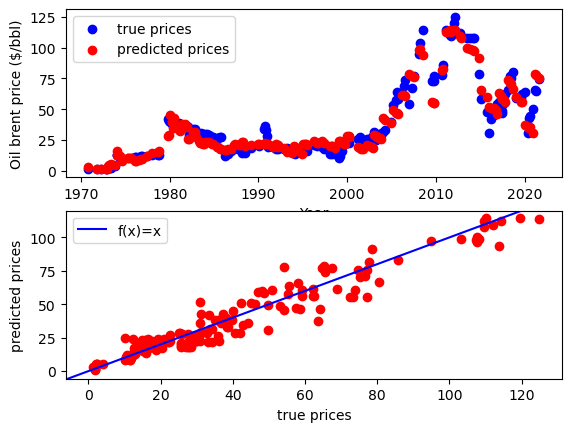

In [26]:
years = years_transform(x_test['Year'])
fig, axs = plt.subplots(2)
axs[0].scatter(years, y_test, color = 'blue', label = 'true prices')
axs[0].scatter(years, y_predict_polynomial_lasso, color = 'red', label = 'predicted prices')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Oil brent price ($/bbl)')
axs[0].legend()

axs[1].scatter(y_test, y_predict_polynomial_lasso, color = 'red')
axs[1].axline((0, 0), slope = 1, color = 'blue', label = 'f(x)=x')
axs[1].set_xlabel('true prices')
axs[1].set_ylabel('predicted prices')
axs[1].legend()
plt.show()

## Decision trees

### Bagging regressor

In [27]:
# different hyper-parameters to try
depths = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
estimators = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50] 
samples_features = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
min_mse = math.inf
max_depth = 0
num_estimators = 0
max_samples_features = 0

for d in depths:
     for e in estimators:
            for sf in samples_features:
                bagging_model = BaggingRegressor(DecisionTreeRegressor(max_depth=d),n_estimators=e, max_samples=sf, max_features=sf)
                bagging_model.fit(x_train, y_train)
                prediction = bagging_model.predict(x_test)
                mse = mean_squared_error(prediction, y_test)
                if mse<min_mse:
                    min_mse = mse
                    max_depth = d
                    num_estimators = e
                    max_samples_features = sf
bagging_model = BaggingRegressor(DecisionTreeRegressor(max_depth=max_depth),n_estimators=num_estimators, max_samples=max_samples_features, max_features=max_samples_features)
bagging_model.fit(x_train, y_train)
y_predict_bagging = bagging_model.predict(x_test)
bagging_r2_score = r2_score(y_test, y_predict_bagging)
bagging_mse = mean_squared_error(y_test, y_predict_bagging)
bagging_cv = cross_validate(bagging_model, df, oil_prices, 4, mean_squared_error, np.mean, False)
print("max_depth: ", max_depth)
print("num_estimators: ", num_estimators)
print("max_samples: ", max_samples_features)
print("max_features: ", max_samples_features)
print("mse: ", bagging_mse)
print("r2 score: ", bagging_r2_score)
print("cv: ", bagging_cv)
model_results["bagging"] = (bagging_r2_score, bagging_mse, bagging_cv)

max_depth:  30
num_estimators:  40
max_samples:  0.7
max_features:  0.7
mse:  18.772287675598246
r2 score:  0.9766799426199607
cv:  26.537329401989965


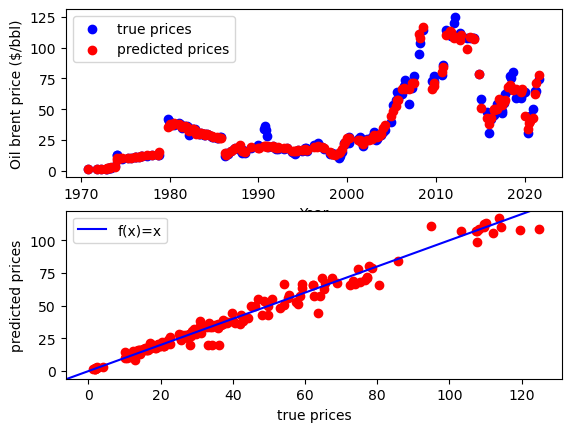

In [28]:
years = years_transform(x_test['Year'])
fig, axs = plt.subplots(2)
axs[0].scatter(years, y_test, color = 'blue', label = 'true prices')
axs[0].scatter(years, y_predict_bagging, color = 'red', label = 'predicted prices')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Oil brent price ($/bbl)')
axs[0].legend()

axs[1].scatter(y_test, y_predict_bagging, color = 'red')
axs[1].axline((0, 0), slope = 1, color = 'blue', label = 'f(x)=x')
axs[1].set_xlabel('true prices')
axs[1].set_ylabel('predicted prices')
axs[1].legend()
plt.show()

### AdaBoost

In [29]:
# tuning the hyper-parameters:
depths = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
estimators = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
min_mse = math.inf
max_depth = 0
num_estimators = 0

for d in depths:
     for e in estimators:
            for sf in samples_features:
                adaboost_model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=d),n_estimators=e)
                adaboost_model.fit(x_train, y_train)
                prediction = adaboost_model.predict(x_test)
                mse = mean_squared_error(prediction, y_test)
                if mse<min_mse:
                    min_mse = mse
                    max_depth = d
                    num_estimators = e
                    max_samples_features = sf
adaboost_model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),n_estimators=num_estimators)
adaboost_model.fit(x_train, y_train)
y_predict_adaboost = adaboost_model.predict(x_test)
adaboost_r2_score = r2_score(y_test, y_predict_adaboost)
adaboost_mse = mean_squared_error(y_test, y_predict_adaboost)
adaboost_cv = cross_validate(adaboost_model, df, oil_prices, 4, mean_squared_error, np.mean, False)
print("max_depth: ", max_depth)
print("num_estimators: ", num_estimators)
print("mse: ", adaboost_mse)
print("r2 score: ", adaboost_r2_score)
print("cv: ", adaboost_cv)
model_results["adaboost"] = (adaboost_r2_score, adaboost_mse, adaboost_cv)

max_depth:  50
num_estimators:  30
mse:  17.406119148936178
r2 score:  0.9783770787912743
cv:  29.301033333333315


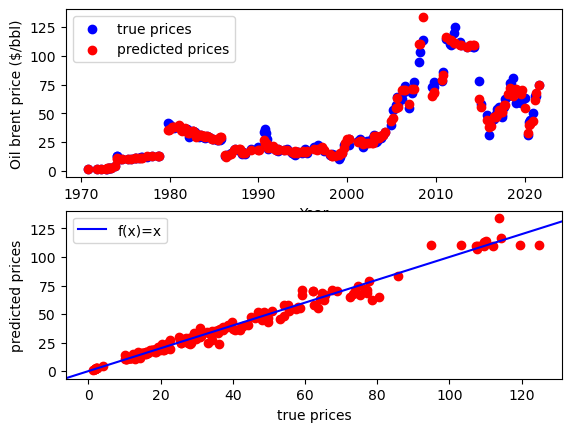

In [30]:
years = years_transform(x_test['Year'])
fig, axs = plt.subplots(2)
axs[0].scatter(years, y_test, color = 'blue', label = 'true prices')
axs[0].scatter(years, y_predict_adaboost, color = 'red', label = 'predicted prices')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Oil brent price ($/bbl)')
axs[0].legend()

axs[1].scatter(y_test, y_predict_adaboost, color = 'red')
axs[1].axline((0, 0), slope = 1, color = 'blue', label = 'f(x)=x')
axs[1].set_xlabel('true prices')
axs[1].set_ylabel('predicted prices')
axs[1].legend()
plt.show()

### Gradient Boosting regressor

In [31]:
gb_model = GradientBoostingRegressor()
gb_model.fit(x_train, y_train)
y_predict_gb = gb_model.predict(x_test)
gb_r2_score = r2_score(y_test, y_predict_gb)
gb_mse = mean_squared_error(y_test, y_predict_gb)
gb_cv = cross_validate(gb_model, df, oil_prices, 4, mean_squared_error, np.mean, False)
print("r2 score: ", gb_r2_score)
print("mse: ", gb_mse)
print("cross_validation: ", gb_cv)
model_results["gradient_boosting"] = (gb_r2_score, gb_mse, gb_cv)

r2 score:  0.9733408879005513
mse:  21.460175391130605
cross_validation:  31.42471264331352


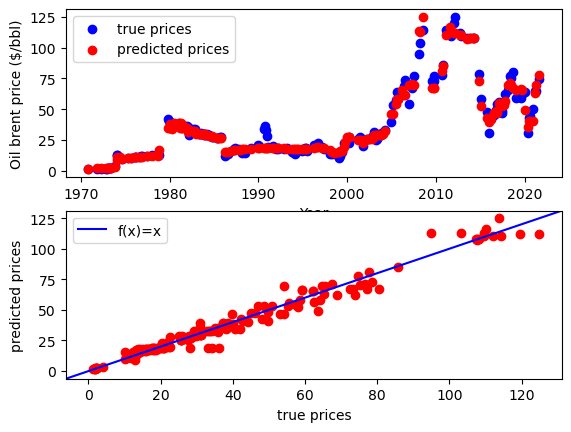

In [32]:
years = years_transform(x_test['Year'])
fig, axs = plt.subplots(2)
axs[0].scatter(years, y_test, color = 'blue', label = 'true prices')
axs[0].scatter(years, y_predict_gb, color = 'red', label = 'predicted prices')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Oil brent price ($/bbl)')
axs[0].legend()

axs[1].scatter(y_test, y_predict_gb, color = 'red')
axs[1].axline((0, 0), slope = 1, color = 'blue', label = 'f(x)=x')
axs[1].set_xlabel('true prices')
axs[1].set_ylabel('predicted prices')
axs[1].legend()
plt.show()

### Extreme Gradient Boosting Regressor

In [33]:
xgb_model = XGBRegressor()
xgb_model.fit(x_train, y_train)
y_predict_xgb = xgb_model.predict(x_test)
xgb_r2_score = r2_score(y_test, y_predict_xgb)
xgb_mse = mean_squared_error(y_test, y_predict_xgb)
xgb_cv = cross_validate(xgb_model, df, oil_prices, 4, mean_squared_error, np.mean, False)
print("r2 score: ", xgb_r2_score)
print("mse: ", xgb_mse)
print("cross-validation score: ", xgb_cv)
model_results["xgb_regressor"] = (xgb_r2_score, xgb_mse, xgb_cv)

r2 score:  0.9798471354848342
mse:  16.22274611081651
cross-validation score:  21.137217438194398


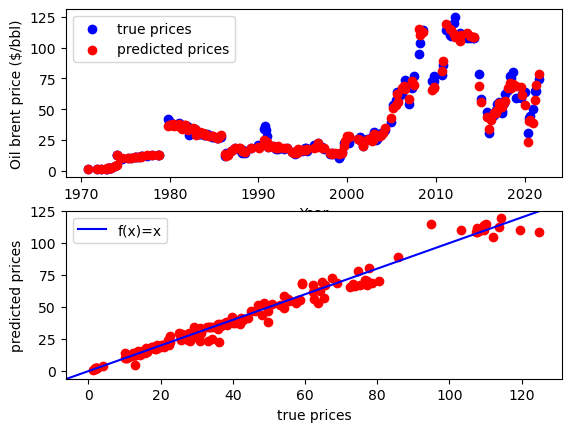

In [34]:
years = years_transform(x_test['Year'])
fig, axs = plt.subplots(2)
axs[0].scatter(years, y_test, color = 'blue', label = 'true prices')
axs[0].scatter(years, y_predict_xgb, color = 'red', label = 'predicted prices')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Oil brent price ($/bbl)')
axs[0].legend()

axs[1].scatter(y_test, y_predict_xgb, color = 'red')
axs[1].axline((0, 0), slope = 1, color = 'blue', label = 'f(x)=x')
axs[1].set_xlabel('true prices')
axs[1].set_ylabel('predicted prices')
axs[1].legend()
plt.show()

### Random forest

In [35]:
forest = RandomForestRegressor()
forest.fit(x_train, y_train)
y_predict_forest = forest.predict(x_test)
forest_r2_score = r2_score(y_test, y_predict_forest)
forest_mse = mean_squared_error(y_test, y_predict_forest)
forest_cv = cross_validate(forest, df, oil_prices, 4, mean_squared_error, np.mean, False)
print("r2 score: ", forest_r2_score)
print("mse: ", forest_mse)
print("cross-validation score: ", forest_cv)
model_results["random_forest"] = (forest_r2_score, forest_mse, forest_cv)

r2 score:  0.9762272905652044
mse:  19.13666562074471
cross-validation score:  39.68439447253206


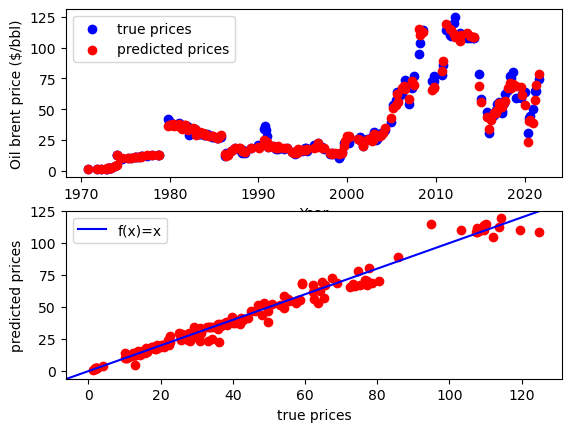

In [36]:
years = years_transform(x_test['Year'])
fig, axs = plt.subplots(2)
axs[0].scatter(years, y_test, color = 'blue', label = 'true prices')
axs[0].scatter(years, y_predict_xgb, color = 'red', label = 'predicted prices')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Oil brent price ($/bbl)')
axs[0].legend()

axs[1].scatter(y_test, y_predict_xgb, color = 'red')
axs[1].axline((0, 0), slope = 1, color = 'blue', label = 'f(x)=x')
axs[1].set_xlabel('true prices')
axs[1].set_ylabel('predicted prices')
axs[1].legend()
plt.show()

## Summing up the results

In [37]:
comparison_r2 = sorted(model_results.items(), key = lambda x:x[1], reverse = True)
print(comparison_r2)

[('xgb_regressor', (0.9798471354848342, 16.22274611081651, 21.137217438194398)), ('adaboost', (0.9783770787912743, 17.406119148936178, 29.301033333333315)), ('bagging', (0.9766799426199607, 18.772287675598246, 26.537329401989965)), ('random_forest', (0.9762272905652044, 19.13666562074471, 39.68439447253206)), ('gradient_boosting', (0.9733408879005513, 21.460175391130605, 31.42471264331352)), ('polynomial_ridge', (0.9439738222549645, 45.10021175566398, 58.406942688419754)), ('polynomial', (0.9310753802454291, 55.48325927669084, 67.31976941384063)), ('polynomial_lasso', (0.9295959706272156, 56.67416127536787, 63.15970906418933)), ('linear_ridge', (0.7641758209058976, 189.83483868292421, 194.77221538394076)), ('linear_regression', (0.7641530766131525, 189.8531474889204, 194.39279868363332)), ('linear_lasso', (0.7633612630700941, 190.4905452179864, 193.28070215377556))]


In [38]:
comparison_mse = sorted(model_results.items(), key = lambda x:(x[1][1], x[1][0], x[1][2]))
print(comparison_mse)

[('xgb_regressor', (0.9798471354848342, 16.22274611081651, 21.137217438194398)), ('adaboost', (0.9783770787912743, 17.406119148936178, 29.301033333333315)), ('bagging', (0.9766799426199607, 18.772287675598246, 26.537329401989965)), ('random_forest', (0.9762272905652044, 19.13666562074471, 39.68439447253206)), ('gradient_boosting', (0.9733408879005513, 21.460175391130605, 31.42471264331352)), ('polynomial_ridge', (0.9439738222549645, 45.10021175566398, 58.406942688419754)), ('polynomial', (0.9310753802454291, 55.48325927669084, 67.31976941384063)), ('polynomial_lasso', (0.9295959706272156, 56.67416127536787, 63.15970906418933)), ('linear_ridge', (0.7641758209058976, 189.83483868292421, 194.77221538394076)), ('linear_regression', (0.7641530766131525, 189.8531474889204, 194.39279868363332)), ('linear_lasso', (0.7633612630700941, 190.4905452179864, 193.28070215377556))]


In [39]:
comparison_cv = sorted(model_results.items(), key = lambda x:(x[1][2], x[1][0], x[1][1]))
print(comparison_cv)

[('xgb_regressor', (0.9798471354848342, 16.22274611081651, 21.137217438194398)), ('bagging', (0.9766799426199607, 18.772287675598246, 26.537329401989965)), ('adaboost', (0.9783770787912743, 17.406119148936178, 29.301033333333315)), ('gradient_boosting', (0.9733408879005513, 21.460175391130605, 31.42471264331352)), ('random_forest', (0.9762272905652044, 19.13666562074471, 39.68439447253206)), ('polynomial_ridge', (0.9439738222549645, 45.10021175566398, 58.406942688419754)), ('polynomial_lasso', (0.9295959706272156, 56.67416127536787, 63.15970906418933)), ('polynomial', (0.9310753802454291, 55.48325927669084, 67.31976941384063)), ('linear_lasso', (0.7633612630700941, 190.4905452179864, 193.28070215377556)), ('linear_regression', (0.7641530766131525, 189.8531474889204, 194.39279868363332)), ('linear_ridge', (0.7641758209058976, 189.83483868292421, 194.77221538394076))]


After several runs with different selected features and averaging strategies, the decision trees seem to be a good choice for a fast oil price prediction.

## PCA transformation on data

In [3]:
#Import and normalize the data

df = pd.read_csv('data_final1.csv')
x = df.loc[:, df.columns != 'Oil brent price ($/bbl)']
y = df['Oil brent price ($/bbl)']

x = (x - x.min()) / (x.max() - x.min())

In [4]:
pca = PCA()
x_pca = pca.fit_transform(x)

explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print(explained_variance_ratio)
print(len(explained_variance_ratio))

# Determine the number of components that explain 90% of the variance
n_components = np.argmax(explained_variance_ratio >= 0.9) + 1

pca = PCA(n_components=n_components)

x_pca = pca.fit_transform(x)

x_pca = pd.DataFrame(x_pca)

selected_features = pca.components_
print(len(selected_features))

[0.69328997 0.81075577 0.85584821 0.89320271 0.92416949 0.94515526
 0.9612409  0.97611674 0.98399289 0.98973713 0.99416307 0.99611857
 0.99790106 0.99906606 0.99948717 0.99967018 0.9997882  0.99987206
 0.99993131 0.99996678 0.99999043 0.99999957 1.        ]
23
5


We need 5 features to get 90% of the variance explained, just as many features as our selection.

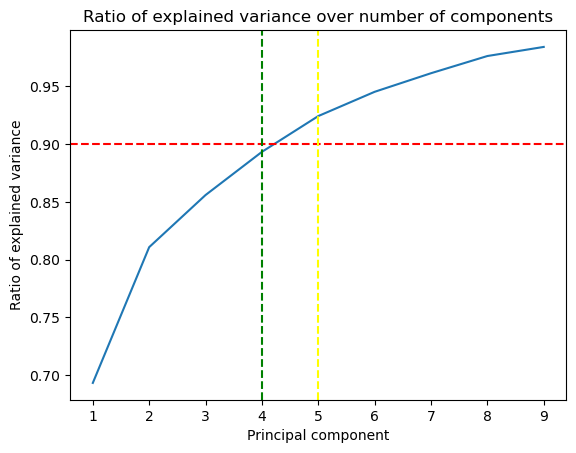

In [5]:
plt.plot(range(1, 10), explained_variance_ratio[:9])
plt.xlabel('Principal component')
plt.ylabel('Ratio of explained variance')
plt.axhline(y=0.9, color='red', linestyle='--')
plt.axvline(x=5, color='yellow', linestyle='--')
plt.axvline(x=4, color='green', linestyle='--')
plt.title('Ratio of explained variance over number of components')
plt.show()

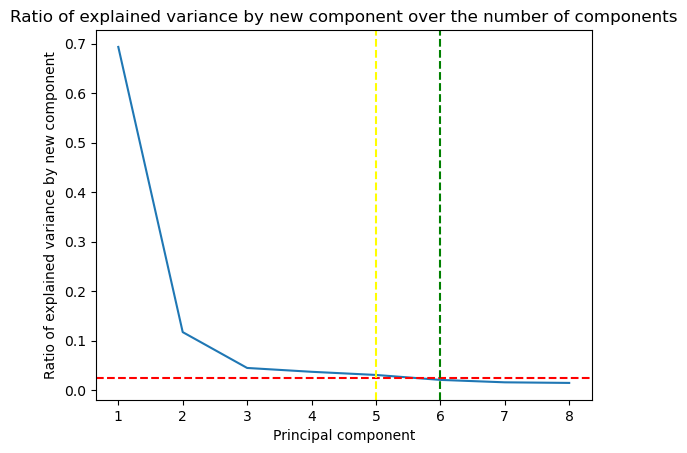

In [6]:
pca = decomposition.PCA(n_components=8)
pca.fit(x)
X_transformed = pca.transform(x)

plt.plot(range(1, 9), pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Ratio of explained variance by new component')
plt.axhline(y=0.025, color='red', linestyle='--')
plt.axvline(x=5, color='yellow', linestyle='--')
plt.axvline(x=6, color='green', linestyle='--')
plt.title('Ratio of explained variance by new component over the number of components')
plt.show()

After 5 components, less than 2.5% of the variance is explained by adding a new parameter, another reason to keep 5 components.

In [7]:
# define models to cross-validate
models = []
models.append(('XGBRegressor',XGBRegressor(),mean_squared_error,np.mean, False))
models.append(('DecisionTree', DecisionTreeRegressor(),mean_squared_error,np.mean, False)) 
models.append(('RandomForest', RandomForestRegressor(),mean_squared_error,np.mean, False))

models_PCA = []
models_PCA.append(('XGBRegressor',XGBRegressor(),mean_squared_error,np.mean, False))
models_PCA.append(('DecisionTree', DecisionTreeRegressor(),mean_squared_error,np.mean, False)) 
models_PCA.append(('RandomForest', RandomForestRegressor(),mean_squared_error,np.mean, False))
#models.append(('LogisticRegression', LogisticRegression(),mean_squared_error,np.mean, False))
stratified=0

# evaluate each model using cross-validation
results = []
n=4
for name, model, score_fn, agg_fn, stratified in models:
    print('raw data')
    print (name, model, score_fn, agg_fn, stratified )
    score=cross_validate(model, x, y, n, score_fn, agg_fn, stratified)
    results.append(score)
    print(score)
    
results_PCA = []
n=4
for name, model, score_fn, agg_fn, stratified in models_PCA:
    print('data transformed by PCA')
    print (name, model, score_fn, agg_fn, stratified )
    score=cross_validate(model, x_pca, y, n, score_fn, agg_fn, stratified)
    results_PCA.append(score)
    print(score)

best_model = models[np.argmin(results)]
print(f'Best_model={best_model}')
best_model_PCA = models_PCA[np.argmin(results_PCA)]
print(f'Best_model={best_model_PCA}')

raw data
XGBRegressor XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) <function mean_squared_error at 0x7f120689d3f0> <function mean at 0x7f12b4675fc0> False
21.477517032977858
raw data
DecisionTree DecisionTreeRegressor() <function mean_squared_error at 0x7f120689d3f0> <function mean at 0x7f12b4675fc0> Fa

First, notice that the model with the lowest mean squared error is XGB regressor in both cases.

We also see that using PCA with 5 components on our data is very efficient as it reduces our error from 621 to 253, more than divides it by 2.

# Feature selection

## Wrapper method  
##   -  Sequential Feature Selector "forward"

['Pandemic (covid)', 'War', 'Electric car registrations', 'World imports', 'OPEC cuts on production']


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


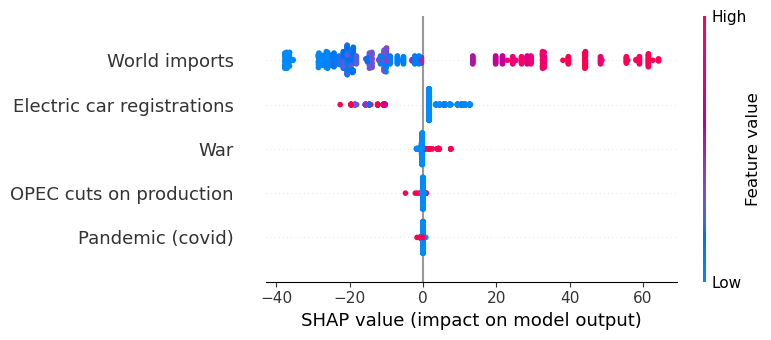

Estimator: RandomForestRegressor()
selected_features: ['World imports', 'Electric car registrations', 'War', 'OPEC cuts on production', 'Pandemic (covid)']

['Pandemic (covid)', 'War', 'Electric car registrations', 'World imports', 'OPEC cuts on production']


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


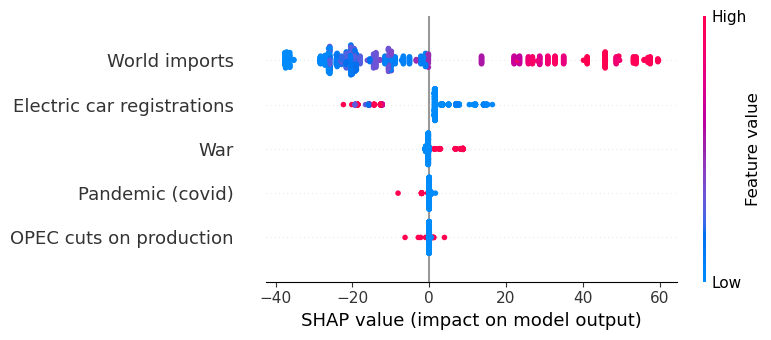

Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
selected_features: ['World imports', 'Electric car registrations', 'War', 'Pandemic (covid)', 'OPEC cuts on production']



In [8]:
estimators = [RandomForestRegressor, XGBRegressor]

for estimator in estimators: 
    selector = SequentialFeatureSelector(estimator=estimator(),
                                         n_features_to_select=5,
                                         direction='forward')

    selector.fit(x, y)


    selected_features = x.columns[selector.support_].tolist()
    

    print(selected_features)
    
    estimator = estimator()
    estimator.fit(x[selected_features], y)
    
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer.shap_values(x[selected_features])
    
    shap.summary_plot(shap_values, x[selected_features], feature_names=selected_features)
    
    selected_feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': np.abs(shap_values).mean(axis=0)})
    selected_feature_importances = selected_feature_importances.sort_values(by='Importance', ascending=False)
    top_5_features = selected_feature_importances['Feature'].head(5).tolist()
        
        
    print(f"Estimator: {estimator}")
    print(f"selected_features: {top_5_features}")
    
    print()





    

## -  Recursive Feature Elimination 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


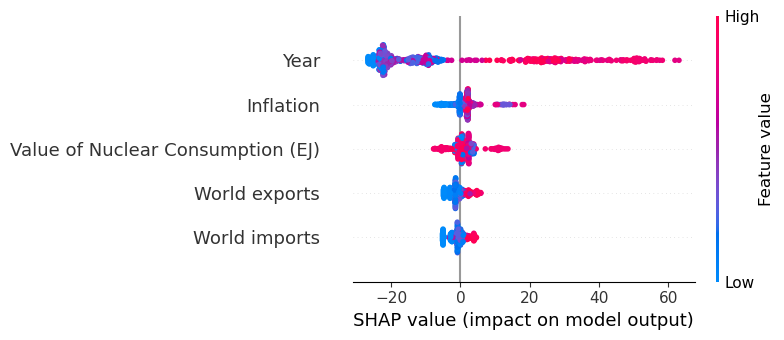

Estimator: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
selected_features: ['Year', 'Inflation', 'Value of Nuclear Consumption (EJ)', 'World exports', 'World imports']



ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


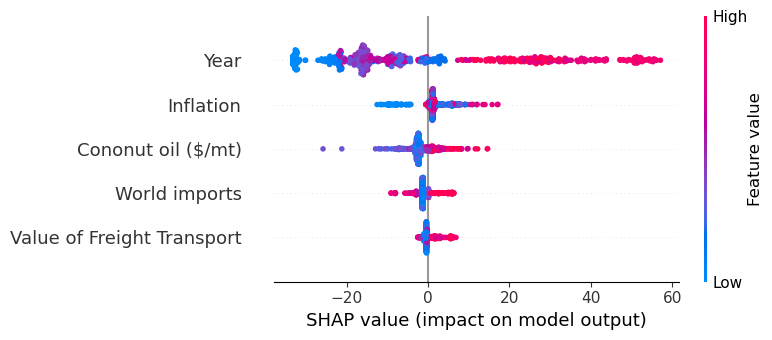

Estimator: <class 'xgboost.sklearn.XGBRegressor'>
selected_features: ['Year', 'Inflation', 'Cononut oil ($/mt)', 'World imports', 'Value of Freight Transport']



In [9]:
estimators = [RandomForestRegressor, XGBRegressor]

for estimator in estimators: 
    model = estimator()
    rfe = RFE(estimator=model, n_features_to_select=5)
    rfe.fit(x, y)
    feature_indices = rfe.get_support(indices=True)
    selected_features = x.columns[feature_indices]

    selected_x = x[selected_features]
    model.fit(selected_x, y)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(selected_x)
    shap.summary_plot(shap_values, selected_x, feature_names=selected_features)

    selected_feature_importances = pd.DataFrame({'Feature': selected_features, 'Importance': np.abs(shap_values).mean(axis=0)})
    selected_feature_importances = selected_feature_importances.sort_values(by='Importance', ascending=False)
    top_5_features = selected_feature_importances['Feature'].head(5).tolist()
        
        
    print(f"Estimator: {estimator}")
    print(f"selected_features: {top_5_features}")
    
    print()



## - Boruta

Boruta trials:   0%|          | 0/20 [00:00<?, ?it/s]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

features accepted: ['Year' 'Cononut oil ($/mt)' 'Sugar ($/kg)'
 'Quantity oil embarked (million of tons)' 'World imports' 'Inflation'
 'Price gold' 'Value of Freight Transport']
features rejected: ['Quantity goods embarked (million of tons)' 'Pandemic (covid)' 'War'
 'Electric car registrations' 'World exports'
 'Value of Solar Consumption (EJ)' 'Value of Wind Consumption (EJ)'
 'Value of Natural Gas Consumption (BcF)' 'Population'
 'OPEC cuts on production' 'GDP Growth' 'World-oil demand']
features tentative: ['Us crude oil reserves' 'Value of Nuclear Consumption (EJ)'
 'Crude oil and NGL production']


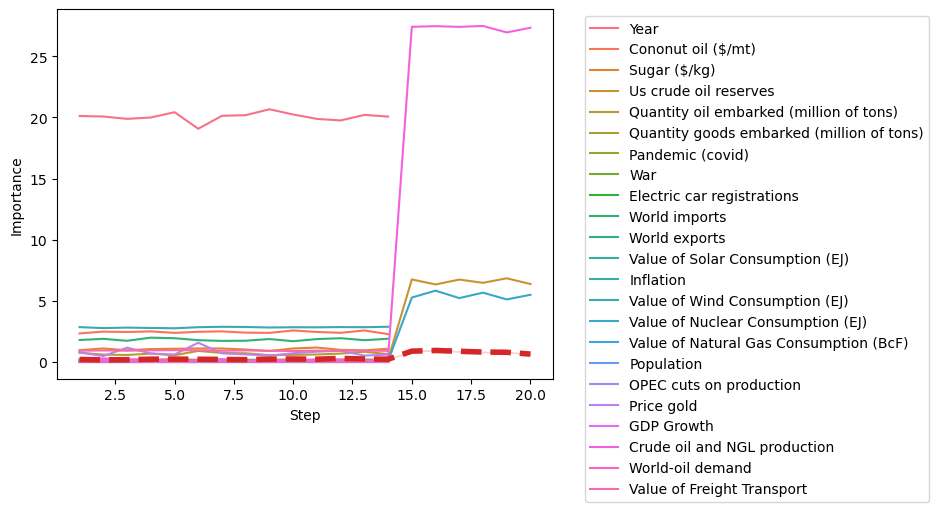

                                      Feature  Importance
0                                        Year   20.353813
12                                  Inflation    2.827759
1                          Cononut oil ($/mt)    2.487869
9                               World imports    1.869873
2                                Sugar ($/kg)    1.062382
22                 Value of Freight Transport    0.936522
18                                 Price gold    0.676606
4     Quantity oil embarked (million of tons)    0.586781
3                       Us crude oil reserves    0.226320
7                                         War    0.154251
20               Crude oil and NGL production    0.112105
19                                 GDP Growth    0.109582
14          Value of Nuclear Consumption (EJ)    0.089184
5   Quantity goods embarked (million of tons)    0.062859
17                    OPEC cuts on production    0.010965
21                           World-oil demand    0.006995
11            

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [10]:
def plot_imp_history(df_history: pd.DataFrame):
    sns.lineplot(x='Step', y='Importance', hue='Feature', data=df_history)
    sns.lineplot(x='Step', y='Threshold', data=df_history, linestyle='--', linewidth=4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
boruta = eBoruta(n_iter = 20, verbose=2, classification = False, test_stratify = False, pvalue = 0.001, percentile = 100) 
boruta.fit(x, y, model = XGBRegressor());
features = boruta.features_
print(f'features accepted: {features.accepted}')
print(f'features rejected: {features.rejected}')
print(f'features tentative: {features.tentative}')

df = features.history
plot_imp_history(df)
r=boruta.rank(sort = True)
print(r)
dictionary = dict(zip(r['Feature'], r['Importance'].apply(lambda x: [x])))
print(dictionary)


## Embelled method
## - XGboost

Index(['Value of Freight Transport', 'Inflation', 'Year', 'World imports',
       'Quantity oil embarked (million of tons)'],
      dtype='object')


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


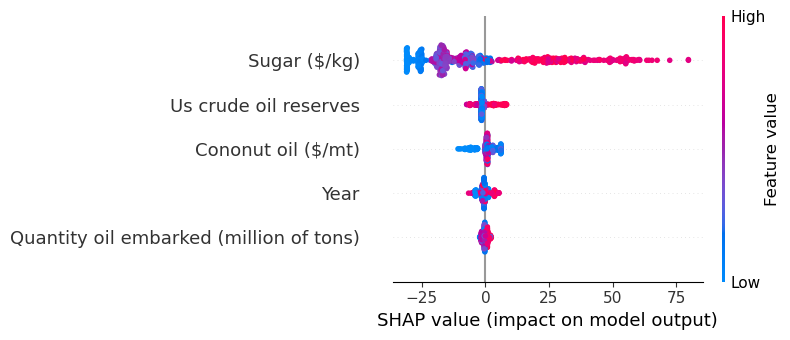

In [11]:

boost = XGBRegressor()
boost.fit(x, y)
p_boost = boost.predict(x)

feature_importance = boost.feature_importances_

top_5_indices = feature_importance.argsort()[-5:][::-1]
top_5_features = x.columns[top_5_indices]
print(top_5_features)

x_top_5 = x[top_5_features]

boost.fit(x_top_5, y)

explainer = shap.TreeExplainer(boost)

shap_values = explainer.shap_values(x_top_5)

shap.summary_plot(shap_values, x_top_5, feature_names=x.columns)






## Filter method
## - Correlation 

World exports                                0.848062
World imports                                0.846612
Value of Freight Transport                   0.821300
Price gold                                   0.818137
Quantity goods embarked (million of tons)    0.770280
Name: Oil brent price ($/bbl), dtype: float64


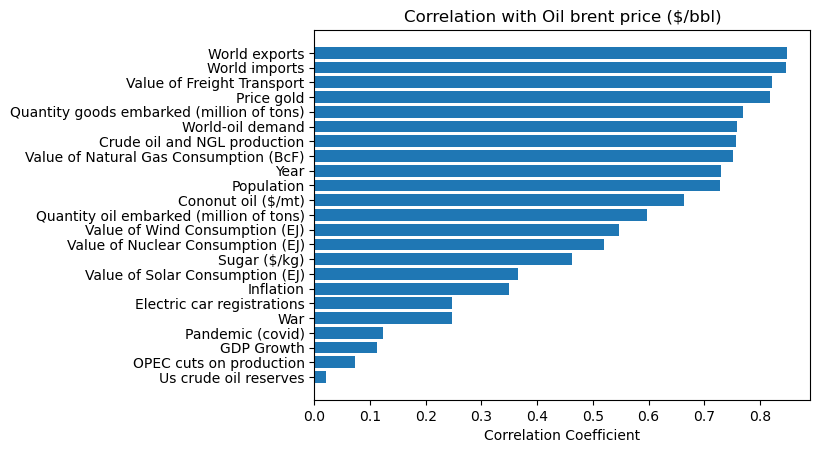

In [12]:
df = pd.read_csv('data_final1.csv')
correlation_matrix = df.corr()

threshold = 0.70

target_correlation = correlation_matrix['Oil brent price ($/bbl)']

target_correlation_sorted = target_correlation.sort_values(ascending=False)

selected_features = 0


print(target_correlation_sorted[1:6])

corr_with_target = df.corr()['Oil brent price ($/bbl)'].abs().sort_values(ascending=True)
d = corr_with_target.to_dict()
del d['Oil brent price ($/bbl)']
data = pd.Series(d)
plt.barh(data.index, data.values)
plt.xlabel('Correlation Coefficient')
plt.title(f'Correlation with Oil brent price ($/bbl)')
plt.show()




## - ANOVA F-v

In [13]:

f_scores, p_values = f_classif(x, y)

feature_scores = pd.DataFrame({'Feature': x.columns, 'F-Score': f_scores, 'p-value': p_values})

feature_scores = feature_scores.sort_values('F-Score', ascending=False)

print(feature_scores[:5])


                                      Feature    F-Score       p-value
18                                 Price gold  43.436120  3.043885e-78
10                              World exports  32.849669  1.474428e-70
9                               World imports  32.462153  3.114629e-70
5   Quantity goods embarked (million of tons)  22.952531  8.055454e-61
22                 Value of Freight Transport  20.611037  6.217251e-58


## Selection

According to the previous studies, the most important parameters, sort in descending order of importance, are:  
- Year
- World imports
- World exports
- Inflation
- Price gold
- War
- OPEC cuts on production

## Correlation

We want to avoid having 2 highly correlated features in our small selection. 

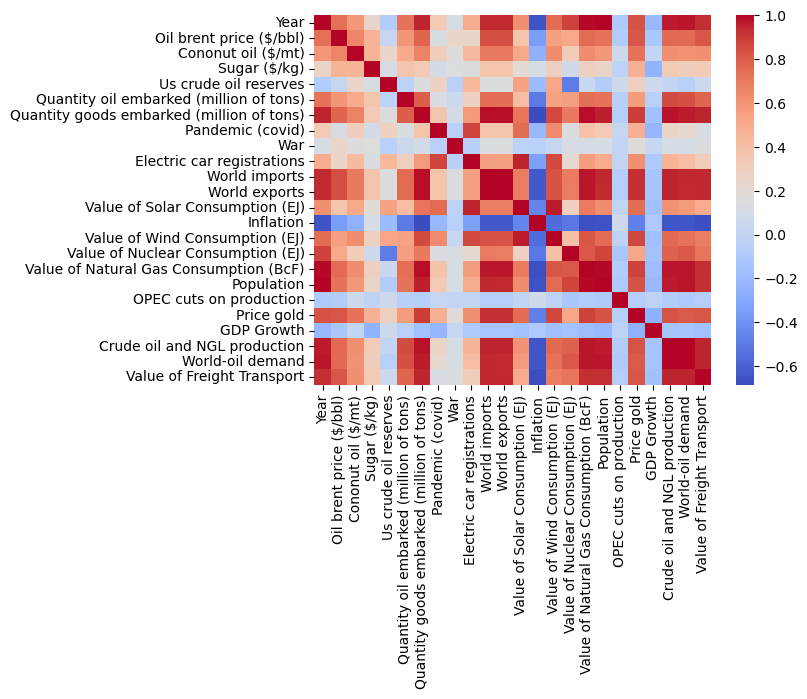

In [14]:

corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)

plt.show()


In [15]:
df2=df.copy()
df2.drop(['Oil brent price ($/bbl)'], 1)
corr_threshold = 0.95

corr_matrix = df.corr().abs()

highly_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] >= corr_threshold:
            feature_i = corr_matrix.columns[i]
            feature_j = corr_matrix.columns[j]
            highly_corr_features.add((feature_i, feature_j))

print("highly_corr_features: ", highly_corr_features)



highly_corr_features:  {('Value of Natural Gas Consumption (BcF)', 'World exports'), ('World-oil demand', 'Crude oil and NGL production'), ('World-oil demand', 'Value of Natural Gas Consumption (BcF)'), ('Value of Wind Consumption (EJ)', 'Value of Solar Consumption (EJ)'), ('Quantity goods embarked (million of tons)', 'Year'), ('Crude oil and NGL production', 'World exports'), ('Population', 'Year'), ('Value of Natural Gas Consumption (BcF)', 'Quantity goods embarked (million of tons)'), ('Crude oil and NGL production', 'Quantity goods embarked (million of tons)'), ('Population', 'Value of Natural Gas Consumption (BcF)'), ('Crude oil and NGL production', 'Population'), ('Value of Freight Transport', 'World-oil demand'), ('World-oil demand', 'Quantity goods embarked (million of tons)'), ('Value of Freight Transport', 'Crude oil and NGL production'), ('World exports', 'World imports'), ('World-oil demand', 'Population'), ('Value of Solar Consumption (EJ)', 'Electric car registrations'), 

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


Since "World exports" and "World imports" are highly correlated, we keep only one of the two (the more important one).  
Here is the final selection (the most important parameters):  
- Year
- World imports
- Inflation
- Price gold
- War

## Retraining with the selected features

Now we want to compare the PCA components with our selected features

In [16]:
x_selected = x[['Year', 'World imports', 'Price gold', 'War', 'Inflation']]

x_selected

,Year,World imports,Price gold,War,Inflation
0,0.000000,0.0,0.000000,0.0,0.378402
1,0.001605,0.0,0.000000,0.0,0.378402
2,0.003210,0.0,0.000109,0.0,0.378402
3,0.004815,0.0,0.000161,0.0,0.378402
4,0.006421,0.0,0.000446,0.0,0.378402
...,...,...,...,...,...
619,0.993579,1.0,0.927898,0.0,0.164874
620,0.995185,1.0,0.922250,0.0,0.164874
621,0.996790,1.0,0.884917,0.0,0.164874
622,0.998395,1.0,0.898570,0.0,0.164874


In [24]:
# define models to cross-validate
models = []
models.append(('XGBRegressor',XGBRegressor(),mean_squared_error,np.mean, False))
models.append(('DecisionTree', DecisionTreeRegressor(),mean_squared_error,np.mean, False)) 
models.append(('RandomForest', RandomForestRegressor(),mean_squared_error,np.mean, False))

models_PCA = []
models_PCA.append(('XGBRegressor',XGBRegressor(),mean_squared_error,np.mean, False))
models_PCA.append(('DecisionTree', DecisionTreeRegressor(),mean_squared_error,np.mean, False)) 
models_PCA.append(('RandomForest', RandomForestRegressor(),mean_squared_error,np.mean, False))

models_selected = []
models_selected.append(('XGBRegressor',XGBRegressor(),mean_squared_error,np.mean, False))
models_selected.append(('DecisionTree', DecisionTreeRegressor(),mean_squared_error,np.mean, False)) 
models_selected.append(('RandomForest', RandomForestRegressor(),mean_squared_error,np.mean, False))

# evaluate each model using cross-validation
results = []
n=4
for name, model, score_fn, agg_fn, stratified in models:
    print('Raw data')
    print (name, model, score_fn, agg_fn, stratified )
    score=cross_validate(model, x_pca, y, n, score_fn, agg_fn, stratified)
    results.append(score)
    print(score)
    
results_PCA = []
n=4
for name, model, score_fn, agg_fn, stratified in models_PCA:
    print('Data transformed by PCA')
    print (name, model, score_fn, agg_fn, stratified )
    score=cross_validate(model, x_pca, y, n, score_fn, agg_fn, stratified)
    results_PCA.append(score)
    print(score)
    
results_selected = []
n=4
for name, model, score_fn, agg_fn, stratified in models_selected:
    print('Data with selected features')
    print (name, model, score_fn, agg_fn, stratified )
    score=cross_validate(model, x_selected, y, n, score_fn, agg_fn, stratified)
    results_selected.append(score)
    print(score)
    
best_model = models[np.argmin(results)]
print(f'Best_model={best_model}')
best_model_PCA = models_PCA[np.argmin(results_PCA)]
print(f'Best_model={best_model_PCA}')
best_model_selected = models[np.argmin(results_selected)]
print(f'Best_model={best_model_selected}')

Raw data
XGBRegressor XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) <function mean_squared_error at 0x7f120689d3f0> <function mean at 0x7f12b4675fc0> False
37.96488074263382
Raw data
DecisionTree DecisionTreeRegressor() <function mean_squared_error at 0x7f120689d3f0> <function mean at 0x7f12b4675fc0> Fal

Once again, XGB regressor is the best model.

We notice that PCA has a better score than our selection: an error of 253 instead of an error of 372.

We also notice that using PCA on our selection is almost useless as we obtain a very similar error of 358.

If we only look at the scores, we deduce that PCA works better than our selection.

But there is a major flaw in this reasoning: PCA does not permit interpretability.
Indeed, the components selected by PCA do not represent any feature, they are created by PCA.

We conclude then that our selection of feature seems very good as it has a rather small error of 372 versus the error of the original data of 621, and it allows interpretability.

We have also used this to confirm that our selection of 5 parameters is very good as it has a lower error than other selections we have tested.

## Going further - Creating a Neural Network

In [25]:
selected_columns = ['Year', 'World imports', 'Price gold', 'War', 'Inflation']
# selected_columns2 = ['Year', 'World imports', 'Cononut oil ($/mt)', 'Sugar ($/kg)', 'Inflation']
xs = x.loc[:, selected_columns]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle = True)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(23,)))
model.add(tf.keras.layers.Dropout(0.2))  # Dropout regularization with a rate of 0.2

model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(23,)))
model.add(tf.keras.layers.Dropout(0.2))  # Dropout regularization with a rate of 0.2

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))  # Dropout regularization with a rate of 0.2

model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(23,)))
model.add(tf.keras.layers.Dropout(0.2))  # Dropout regularization with a rate of 0.2

model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(23,)))
model.add(tf.keras.layers.Dropout(0.2))  # Dropout regularization with a rate of 0.2

model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

loss = model.evaluate(X_test, y_test)
print(loss)

Epoch 1/10
16/16 [==============================] - 1s 13ms/step - loss: 2236.1384 - val_loss: 1340.5752
Epoch 2/10
16/16 [==============================] - 0s 5ms/step - loss: 981.5859 - val_loss: 360.5038
Epoch 3/10
16/16 [==============================] - 0s 5ms/step - loss: 608.3537 - val_loss: 317.2720
Epoch 4/10
16/16 [==============================] - 0s 5ms/step - loss: 462.0696 - val_loss: 352.4219
Epoch 5/10
16/16 [==============================] - 0s 5ms/step - loss: 477.1490 - val_loss: 244.5076
Epoch 6/10
16/16 [==============================] - 0s 5ms/step - loss: 418.1427 - val_loss: 216.3592
Epoch 7/10
16/16 [==============================] - 0s 4ms/step - loss: 411.7521 - val_loss: 208.1018
Epoch 8/10
16/16 [==============================] - 0s 4ms/step - loss: 395.7916 - val_loss: 270.1295
Epoch 9/10
16/16 [==============================] - 0s 4ms/step - loss: 361.6253 - val_loss: 180.9266
Epoch 10/10
4/4 [==============================] - 0s 2ms/step - loss: 120.0092

4/4 [==============================] - 0s 2ms/step


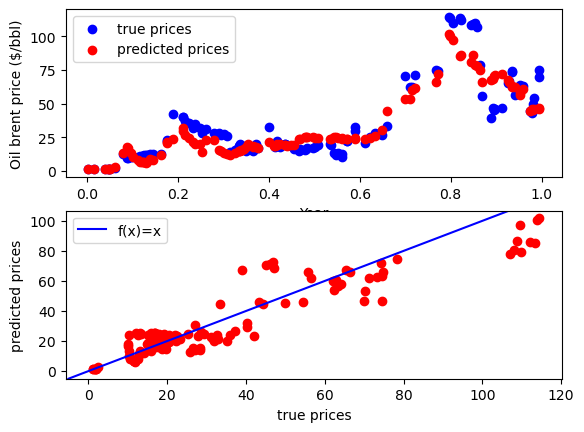

In [27]:
y_pred = model.predict(X_test)
years = X_test['Year']
fig, axs = plt.subplots(2)
axs[0].scatter(years, y_test, color = 'blue', label = 'true prices')
axs[0].scatter(years, y_pred, color = 'red', label = 'predicted prices')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Oil brent price ($/bbl)')
axs[0].legend()

axs[1].scatter(y_test, y_pred, color = 'red')
axs[1].axline((0, 0), slope = 1, color = 'blue', label = 'f(x)=x')
axs[1].set_xlabel('true prices')
axs[1].set_ylabel('predicted prices')
axs[1].legend()
plt.show()

This new model we created has a lower score for our selected data than XGB regressor or Random Forest, up to 10 times worse.
We should keep in mind that neural networks are likely to overfit if we complexify them too much.